# 0. Initialize

## 0.1. Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm, metrics, tree
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import VotingClassifier

## 0.2. DEFINE VARIABLES 

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [3]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
trainingTweetDf = pd.read_csv('training-tweet.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1418828259614236672,No
1,1424439289753083911,No
2,1354305766644199427,Yes
3,1438890637282193408,Yes
4,1397543048452591616,No
...,...,...
2995,1416144676990722053,Yes
2996,1466793383788220421,Yes
2997,1448350353439744003,Yes
2998,1423327989044072453,Yes


In [4]:
trainingTweetDf.isPolitical.value_counts()

No     1509
Yes    1491
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [4]:
#trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf = pd.read_csv('training-user.csv')
trainingUserDf

,screen_name,isBot
0,faracyaziyor,No
1,elifgibirt,No
2,buocguldurdu,No
3,__baba1yaga_,No
4,hakanyilmazcebi,No
...,...,...
2995,kupakralicesi53,No
2996,muhamme44063672,No
2997,galaopta,Not sure
2998,hygea0,No


In [6]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

## 1. Landing Page

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [6]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [7]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [8]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [9]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [10]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [11]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [226]:

def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag',
                        'akparti', 'AKP', 'herkesicinchp', 'CHP', 'ekrem_imamoglu', 'erdoğan', '06melihgokcek', 
                        'kılıçdaroğlu', 'mansuryavas06', 'mansuryavas', 'bahçeli', 'ABD', 'amerika', 
                        'drfahrettinkoca', 'suleymansoylu', 'tcbestepe', 'NureddinNebati', 'tcmeb', 'ziyaselcuk', 
                        'MHP', 'nato', 'almanya', 'rusya', 'atama', 'sağlıkçı', 'meral akşener', 'atatürk', 
                        'mustafa kemal', 'adalet', 'fetö', 'demirtaş', '🇹🇷']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities
 


In [13]:
def check_non_political_ent(text):
    
    list_of_sport = ['FileninSultanları', 'tokyo2020', 'tokyo 2020', 'hayırlı cumalar', 'cumamız mübarek olsun', 
                     'stadyum', 'rahmet', 'hayırlı sabahlar', 'hayırlı akşamlar', 'teknofest', 'fenerbahçe', 
                     'galatasaray', 'beşiktaş', 'fb', 'gs', 'bjk', 'trabzonspor', 'ts', 'konyaspor', 'kuran',
                     'din', 'allah', 'spor', 'yoğun bakım', 'hastane', 'pandemi', 'covid', 'omnicron', 'aşı', 
                     'bizimçocuklar', 'teknofest', '#teknofest', 'covid-19', 'tedavi']
    
    entities_in_text = [ent for ent in list_of_sport if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [116]:
def check_sport_ent(text):
    
    list_of_sport = ['spor', 'tokyo2020', 'tokyo 2020', 'teknofest', 'bilim', 'olimpiyat']
    
    entities_in_text = [ent for ent in list_of_sport if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [15]:
def check_religion_ent(text):
    
    list_of_religion = ['covid-19', 'tedavi']
    
    entities_in_text = [ent for ent in list_of_religion if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [149]:
def check_health_ent(text):
    
    list_of_religion = ['allah', 'cuma', 'din', 'mübarek']
    
    entities_in_text = [ent for ent in list_of_religion if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [319]:
def user_description_politic(text):
    
    list_of_politics = ['Ak parti', 'RTE']
    
    entities_in_text = [ent for ent in list_of_politics if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [92]:
def retweet_politic_func(text):
    
    
    list_of_politics = ['meral_aksener', 'kilicdarogluk', 'MevlutCavusoglu', 'herkesicinchp', 'CHP', 
                        'ekrem_imamoglu', 'drfahrettinkoca']

    
    entities_in_text = [ent for ent in list_of_politics if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)
   
    return number_entities

In [18]:
def has_link(text):
    
    link = ["http"]
    entities_in_text = [ent for ent in link if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)
    
    if(number_entities >= 1):
        return 1
    else:
        return 0

#### 1.1.2.2. Number of total interactions

In [19]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count 
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [320]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[],
                'num_non_political_entities' : [],
              'total_interactions':[],
               'difference' : [],
               'description_political' : [],
               'is_retweet_politic' : [],
               'sport_ent':[],
              'religion_ent':[],
               'has_link' : [],
               'health_ent' : []
              }


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)
        
        non_num_political_ent = check_non_political_ent(text)
        religion_ent = check_religion_ent(text)
        
        description_politic_num = user_description_politic(user_description)
        sport_ent = check_sport_ent(text)
        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        
        difference = num_political_entities - non_num_political_ent
        
        if(is_retweet == 1):
            retweet_politic = retweet_politic_func(retweeted_username)
        else: 
            retweet_politic = 0
        
        link = has_link(text)
        
        num_health_entities = check_health_ent(text)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['num_non_political_entities'].append(non_num_political_ent)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['difference'].append(difference)
        dfPolitical['description_political'].append(description_politic_num)
        dfPolitical['is_retweet_politic'].append(retweet_politic)
        dfPolitical['sport_ent'].append(sport_ent)
        dfPolitical['religion_ent'].append(religion_ent)
        dfPolitical['has_link'].append(link)
        dfPolitical['health_ent'].append(num_health_entities)

In [321]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,num_non_political_entities,total_interactions,difference,description_political,is_retweet_politic,sport_ent,religion_ent,has_link,health_ent
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,1,0,0,0,0,0,0,0,1
1,1445677417150889986,1,ekrem_imamoglu,RT @ekrem_imamoglu: Geldikleri gibi gittiler… ...,1,0,6706,0,1263130166961864705,hasanak11633015,64 Jahre alt,1,0,6706,1,0,1,0,0,1,0
2,1456638729620230149,1,yenisafak,RT @yenisafak: İYİ PARTİLİ TÜRKKAN ŞEHİT AĞABE...,1,0,1545,0,2958652582,buyukdogu58,Katılıyorum: RT+FAV,1,0,1545,1,0,0,0,0,0,0
3,1451295314074341381,1,ekrem_imamoglu,RT @ekrem_imamoglu: Bu gece ben: ❤️💛\nTebrikle...,1,0,7470,0,1447285927471112194,gskaya444,,1,1,7470,0,0,1,0,0,0,0
4,1440610747134844929,1,umitozdag,RT @umitozdag: Sayın Bakan demek yüzmeyi öğren...,1,0,745,0,379944275,cerenncan,,1,1,745,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,1439639972177489926,1,deryayanikashb,RT @deryayanikashb: AK Parti Çanakkale İl Başk...,1,0,48,0,165689533,sezayicimen,İst.Aydın Üniversitesi Mahalli İdareler ve Yer...,0,0,48,0,0,0,0,0,0,0
32998,1467519965473423362,1,kilicdarogluk,RT @kilicdarogluk: Türkiye Barolar Birliği 36....,1,0,4438,0,408719429,sdiplen1,Hepimiz birileri için kurallarımızı çiğnedik,1,0,4438,1,0,1,0,0,0,0
32999,1423666826282668035,1,rterdogan,RT @RTErdogan: Geleceğe Nefes kampanyasıyla he...,1,0,14311,0,1004379711890485248,soguzsoylu,AK Parti Yumurtalık İlçe Başkanı,1,2,14311,-1,1,0,0,0,0,1
33000,1417025303894007810,1,thetubaca,RT @thetubaca: Hasta tutuklu Ekim Polat açlık ...,3,0,16,0,1049663929348222985,mhmt_ckmk04,667 ile yılları çalınan gurebadan bir garip...,2,0,16,2,0,0,0,0,0,0


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [22]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [23]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [24]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [25]:
def check_political_name(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['akparti', 'AKP', 'AK Parti', 'CHP', 'erdoğan', 'rte', 'mansuryavas', 'bahçeli', 'ABD', 'amerika', 
                        'tcmeb', 'MHP', 'nato', 'almanya', 'rusya', 'atama', 'sağlıkçı', 'adalet', 'fetö']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [26]:
def check_name_number(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    counter = 0
    for i in text:
        if (i in list_of_entities):
            counter = counter + 1
    
    return counter

In [27]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
        'num_political_names':[],
        'num_username_numbers':[]}

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        num_political_names = check_political_name(dictionary['user_description'])
        dfBot['num_political_names'].append(num_political_names)
        
        num_username_number = check_name_number(dictionary['user_name'])
        dfBot['num_username_numbers'].append(num_username_number)
        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [28]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,num_political_names,num_username_numbers
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,1,0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,2
...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0,0
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0,0


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [29]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

In [30]:
def get_tweet_count(line):
    number_retweets = 0
    number_original_tweets = 0
    
    info_arr = []
    
    
    for tweet in line['tweets']:
        
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets      
    
    info_arr = [number_original_tweets, number_retweets, total_tweets]
    
    return info_arr

#### 1.2.2.2. Check median number of favorites

In [31]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

In [32]:
def get_same_day_tweets(line):
    dateList = []
    counterdate = 0
    for tweet in line['tweets']:    
        if(tweet['created_at'][0:10] not in dateList):
            dateList.append(tweet['created_at'][0:10])
        else:
            counterdate = counterdate + 1
            
    return counterdate

In [33]:
def get_same_tweet(line):
    textList = []
    countertext = 0
    for tweet in line['tweets']:


        if(tweet['text'] not in textList):
            textList.append(tweet['text'])
        else:
            countertext = countertext + 1
            
            
    if (countertext > 0):
        return 1
    else:
        return 0

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [34]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[],
              'num_of_retweets':[],
              'num_of_alltweets':[],
              'same_day_tweets_total' : [],
              'same_tweet' : [],
              'same_day_to_all' : []}

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:

        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)
        
        arr = get_tweet_count(line)
        
        dfBotTweets['num_of_tweets'].append(arr[0])
        dfBotTweets['num_of_retweets'].append(arr[1])
        dfBotTweets['num_of_alltweets'].append(arr[2])
        
        same_day_tweets = get_same_day_tweets(line)
        if(arr[2] != 0):
            same_day_tweets_to_all = same_day_tweets / arr[2]
        else:
            same_day_tweets_to_all = 0
        has_same_tweet = get_same_tweet(line)
        
        
        dfBotTweets['same_day_tweets_total'].append(same_day_tweets)
        dfBotTweets['same_tweet'].append(has_same_tweet)
        dfBotTweets['same_day_to_all'].append(same_day_tweets_to_all)
        

        i += 1
        
        if i % 10000 == 0:
            print(i)

C:\Users\Msi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Msi\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000


In [35]:
dfBotTweets = pd.DataFrame.from_dict(dfBotTweets, orient = 'index')


In [36]:
dfBotTweets = dfBotTweets.transpose()
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all
0,1044821071,0.09,57.0,182,18,200,73,0,0.365
1,1086355147,0.172973,10.0,153,32,185,30,0,0.162162
2,205625453,0.0,9.0,200,0,200,194,0,0.97
3,1382717948092157953,0.356784,0.0,128,71,199,170,1,0.854271
4,1302055645307375618,0.646154,0.0,69,126,195,171,0,0.876923
...,...,...,...,...,...,...,...,...,...
29901,1865050056,0.890411,0.0,8,65,73,65,0,0.890411
29902,1336329028324577281,0.78392,0.0,43,156,199,148,0,0.743719
29903,1214219054329675777,0.970588,0.0,5,165,170,167,0,0.982353
29904,310390437,0.875,0.0,25,175,200,194,1,0.97


### 1.2.3. Merge dfBot and dfBotTweets

In [37]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites', 'num_of_alltweets', 'num_of_retweets', 'num_of_tweets' ]] = dfBotAll[['retweet_total_ratio', 'num_median_favorites',  'num_of_alltweets', 'num_of_retweets', 'num_of_tweets' ]].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,num_political_names,num_username_numbers,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0,0.060,1.0,188,12,200,124,0,0.62
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0,0.200,107.0,160,40,200,48,0,0.24
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,1,0,0.230,1.0,154,46,200,132,0,0.66
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0,0.000,0.0,0,0,0,NaN,NaN,NaN
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,2,1.000,0.0,0,200,200,198,1,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0,0,0.735,0.0,53,147,200,165,0,0.825
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0,0.020,1.0,196,4,200,140,1,0.7
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0,0.000,24.0,200,0,200,93,0,0.465
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0,0,0.000,76.5,200,0,200,190,0,0.95


In [38]:
dfBotAll = dfBot.merge(right = dfBotTweets, left_on = "user_id", right_on = "user_id", how='left')
dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,num_political_names,num_username_numbers,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0,0.06,1.0,188,12,200,124,0,0.62
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0,0.2,107.0,160,40,200,48,0,0.24
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,1,0,0.23,1.0,154,46,200,132,0,0.66
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,2,1.0,0.0,0,200,200,198,1,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0,0,0.735,0.0,53,147,200,165,0,0.825
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0,0.02,1.0,196,4,200,140,1,0.7
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0,0.0,24.0,200,0,200,93,0,0.465
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0,0,0.0,76.5,200,0,200,190,0,0.95


In [39]:
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all
0,1044821071,0.09,57.0,182,18,200,73,0,0.365
1,1086355147,0.172973,10.0,153,32,185,30,0,0.162162
2,205625453,0.0,9.0,200,0,200,194,0,0.97
3,1382717948092157953,0.356784,0.0,128,71,199,170,1,0.854271
4,1302055645307375618,0.646154,0.0,69,126,195,171,0,0.876923
...,...,...,...,...,...,...,...,...,...
29901,1865050056,0.890411,0.0,8,65,73,65,0,0.890411
29902,1336329028324577281,0.78392,0.0,43,156,199,148,0,0.743719
29903,1214219054329675777,0.970588,0.0,5,165,170,167,0,0.982353
29904,310390437,0.875,0.0,25,175,200,194,1,0.97


In [40]:
eren_user = pd.read_csv('annotated_users_eren.csv')
eren_user = eren_user[['Unnamed: 0', 'isBot']]
eren_user = eren_user.rename(columns = {'Unnamed: 0' : 'user_screen_name'})


dfBotAll_train_eren = dfBotAll.merge(eren_user,
                               left_on='user_screen_name',
                               right_on='user_screen_name')



alp_user = pd.read_csv('annotated_users_alp.csv')
alp_user = alp_user[['Unnamed: 0', 'isBot']]
alp_user = alp_user.rename(columns = {'Unnamed: 0' : 'user_screen_name'})


dfBotAll_train_alp = dfBotAll.merge(alp_user,
                               left_on='user_screen_name',
                               right_on='user_screen_name')


tuna_user = pd.read_csv('annotated_users_tuna.csv')
tuna_user = tuna_user[['Unnamed: 0', 'isBot']]
tuna_user = tuna_user.rename(columns = {'Unnamed: 0' : 'user_screen_name'})


dfBotAll_train_tuna = dfBotAll.merge(tuna_user,
                               left_on='user_screen_name',
                               right_on='user_screen_name')

egemen_user = pd.read_csv('annotated_users_egemen.csv')
egemen_user = egemen_user[['Unnamed: 0', 'isBot']]
egemen_user = egemen_user.rename(columns = {'Unnamed: 0' : 'user_screen_name'})


dfBotAll_train_egemen = dfBotAll.merge(egemen_user,
                               left_on='user_screen_name',
                               right_on='user_screen_name')



berk_user = pd.read_csv('annotated_users_berk.csv')
berk_user = berk_user[['Unnamed: 0', 'isBot']]
berk_user = berk_user.rename(columns = {'Unnamed: 0' : 'user_screen_name'})


dfBotAll_train_berk = dfBotAll.merge(berk_user,
                               left_on='user_screen_name',
                               right_on='user_screen_name')


all_annotation_user = pd.concat([dfBotAll_train_berk, dfBotAll_train_egemen, dfBotAll_train_tuna, dfBotAll_train_alp, dfBotAll_train_eren], ignore_index=True)
#all_annotation = all_annotation.dropna()
all_annotation_user

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,num_political_names,num_username_numbers,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all,isBot
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0,0.06,1.0,188,12,200,124,0,0.62,No
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0,0.2,107.0,160,40,200,48,0,0.24,No
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,1,0,0.23,1.0,154,46,200,132,0,0.66,No
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not sure
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,2,1.0,0.0,0,200,200,198,1,0.99,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,79194034,Dinçer Güner,dincerguner,İstanbul,"Astrolog, Yazar, Köşe Yazarı @MarieClaireTR ...",592191,20223,130,0.966978,0,0,0.015,89.0,197,3,200,195,0,0.975,No
1246,1224381312783527936,Servet Polat,spolatrt,"Çankaya, Ankara",ÖLMEK VAR DÖNMEK YOK.KARINCA MİSALİ SAFIMIZ BE...,5895,6358,113,0.481107,0,0,1.0,0.0,0,191,191,189,0,0.989529,No
1247,880900730407849984,Doğal Afet Rüya Yo..,orhan3478,"Karabük, Türkiye İRT NO : 5394",Karabük kardemir işçi emeklisi,6638,2899,30,0.696026,0,0,0.13,0.0,174,26,200,127,0,0.635,Yes
1248,797540035163750400,Yaren,yxrasl,Nordrhein-Westfalen,xulamê çavên reş belek,422,391,22,0.519065,0,0,0.015,0.0,197,3,200,125,0,0.625,No


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [322]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,num_non_political_entities,total_interactions,difference,description_political,is_retweet_politic,sport_ent,religion_ent,has_link,health_ent,isPolitical
0,1422716317359083524,1,ekrem_imamoglu,RT @ekrem_imamoglu: Alarmı kurduk! Sanmayın ki...,1,1,3596,0,1151776206427234304,oykulovic,Bu terslikte bi iş var🦥,2,1,3596,1,0,1,0,0,1,0,No
1,1443994036847710225,1,habermujdeli,RT @HaberMujdeli: İSPARK niye zarar etsin diye...,1,0,1252,0,1029972980707860485,erefdnmez6,"Reisinin emrinde, Ak parti gönüllüsü, Vatanın,...",0,1,1252,-1,1,0,0,0,1,0,Yes
2,1448987280740438016,1,ibrahim_yka,RT @ibrahim_yka: Hüsniye Erdoğan Mini HDP 9 8...,1,0,36,0,1381515272406900738,nurierdemli1,,2,1,36,1,0,0,0,0,0,1,Yes
3,1436370160731017219,1,feoist,RT @feoist: @drfahrettinkoca Allah senin çocuk...,2,0,1,0,1361792750375628800,ismail93613027,,1,2,1,-1,0,0,0,0,0,1,No
4,1425552306104307724,1,akparti,RT @Akparti: Cumhurbaşkanımız @RTErdogan: Teme...,2,1,543,0,763812418724200448,ebru_gursultur,,3,0,543,3,0,0,0,0,1,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1471184915047895044,0,None,@Ayse_439617 @AilebakEkders @ABEPDERNEK @derya...,5,0,1,0,1361730369112973313,a439617,,1,0,1,1,0,0,0,0,1,0,Yes
2996,1447868445173899264,0,None,@YK06091 Bizlerde bu başarı belgelerine talibi...,0,0,0,1,1436208094657318912,yusuf_yaliniz,,1,0,1,1,0,0,0,0,1,0,Yes
2997,1417903713746882572,0,None,@birogrenci177 @turkcedusunuyor @drfahrettinko...,3,0,0,1,1230846507395538947,burakkrtw,“Herkesi dinlerim ama kendi doğru bildiğimi ya...,1,1,1,0,0,0,0,0,1,0,Yes
2998,1359654986087620608,0,None,@sercan_zorbozan Rabbim yardimcilari olsun,0,0,0,0,553934347,qilloali,Düsman oklari nereyi vuruyorsa bize orasi mevz...,0,0,0,0,0,0,0,0,0,0,No


In [323]:
eren_tweet = pd.read_csv('annotated_tweets_eren.csv')
eren_tweet = eren_tweet[['Unnamed: 0', 'isPolitical']]
eren_tweet = eren_tweet.rename(columns = {'Unnamed: 0' : 'tweet_id'})

eren_tweet['tweet_id'] = eren_tweet['tweet_id'].astype(str)
dfPoliticalAll_eren_train = dfPolitical.merge(eren_tweet,
                                         on='tweet_id')



berk_tweet = pd.read_csv('annotated_tweets_CS4124baf2b642299.csv')
berk_tweet = berk_tweet[['Unnamed: 0', 'isPolitical']]
berk_tweet = berk_tweet.rename(columns = {'Unnamed: 0' : 'tweet_id'})

berk_tweet['tweet_id'] = berk_tweet['tweet_id'].astype(str)
dfPoliticalAll_berk_train = dfPolitical.merge(berk_tweet,
                                         on='tweet_id')

alp_tweet = pd.read_csv('annotated_tweets_CS4122ea963c3ea10.csv')
alp_tweet = alp_tweet[['Unnamed: 0', 'isPolitical']]
alp_tweet = alp_tweet.rename(columns = {'Unnamed: 0' : 'tweet_id'})

alp_tweet['tweet_id'] = alp_tweet['tweet_id'].astype(str)
dfPoliticalAll_alp_train = dfPolitical.merge(alp_tweet,
                                         on='tweet_id')

tuna_tweet = pd.read_csv('annotated_tweets_CS41220484115d956.csv')
tuna_tweet = tuna_tweet[['Unnamed: 0', 'isPolitical']]
tuna_tweet = tuna_tweet.rename(columns = {'Unnamed: 0' : 'tweet_id'})

tuna_tweet['tweet_id'] = tuna_tweet['tweet_id'].astype(str)
dfPoliticalAll_tuna_train = dfPolitical.merge(tuna_tweet,
                                         on='tweet_id')

egemen_tweet = pd.read_csv('annotated_tweets_CS41220484115d956.csv')
egemen_tweet = egemen_tweet[['Unnamed: 0', 'isPolitical']]
egemen_tweet = egemen_tweet.rename(columns = {'Unnamed: 0' : 'tweet_id'})

egemen_tweet['tweet_id'] = egemen_tweet['tweet_id'].astype(str)
dfPoliticalAll_egemen_train = dfPolitical.merge(egemen_tweet,
                                         on='tweet_id')
all_annotation = pd.concat([dfPoliticalAll_berk_train, dfPoliticalAll_alp_train, dfPoliticalAll_egemen_train, dfPoliticalAll_tuna_train, dfPoliticalAll_eren_train], ignore_index=True)
#all_annotation = all_annotation.dropna()
all_annotation

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,num_non_political_entities,total_interactions,difference,description_political,is_retweet_politic,sport_ent,religion_ent,has_link,health_ent,isPolitical
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,1,0,0,0,0,0,0,0,1,Yes
1,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,0,0,0,0,0,0,1,0,No
2,1446578802507780102,0,None,sikmisim merkür retrosunu ya,0,0,0,10,1374129089217490944,ggukvf,ben senin arkadaşın değilim ucube,0,0,10,0,0,0,0,0,0,0,No
3,1405470915928989696,0,None,"@baranthejustice İlk dozu oldum, beni salın ya 😂",1,0,0,0,176495707,gokcuuu,Avocado at Law 🥑⚖\nİstanbul Barosu,0,0,0,0,0,0,0,0,0,0,No
4,1471723948110979073,0,None,@farukerdem @huseyin_ogrtm42 Ücretli öğretmenl...,2,0,1,1,1353803149744726016,garipyolcu_70,Momento Mori,0,0,2,0,0,0,0,0,1,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,1473692474849771521,1,zeydankaralar01,RT @ZeydanKaralar01: CANLI | Genel Başkanımız ...,1,0,45,0,1415568837660102659,oguzhankaya0101,Adana Büyükşehir Belediyesi Otogar ve Otopark ...,1,0,45,1,0,0,0,0,1,0,No
1246,1473683880322506757,1,akparti,RT @Akparti: Genel Başkanımız ve Cumhurbaşkanı...,2,0,734,0,1459486163891335176,kurtmelih861,ELEKTRİK ELEKTRONİK MÜHENDİSLİĞİ 📚\nFENERBAHÇE 💙💛,3,0,734,3,0,0,0,0,1,0,Yes
1247,1436001991642189830,1,denizmavisi013,RT @denizmavisi013: @RTErdogan HAK İHLALLERİ V...,5,0,1,0,1421447262815797248,ahmette87423479,,1,0,1,1,0,0,0,0,0,0,No
1248,1423153369187815424,1,mertarmagan53,RT @MertArmagan53: Yangının ilk gününden bu ya...,1,0,607,0,1374321818262192133,aysegulgullu2,,0,0,607,0,0,0,0,0,0,0,Yes


In [324]:
dfPoliticalAll_train = pd.concat([all_annotation, dfPoliticalAll_train], ignore_index=True)
dfPoliticalAll_train

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,num_non_political_entities,total_interactions,difference,description_political,is_retweet_politic,sport_ent,religion_ent,has_link,health_ent,isPolitical
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,1,0,0,0,0,0,0,0,1,Yes
1,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,0,0,0,0,0,0,1,0,No
2,1446578802507780102,0,None,sikmisim merkür retrosunu ya,0,0,0,10,1374129089217490944,ggukvf,ben senin arkadaşın değilim ucube,0,0,10,0,0,0,0,0,0,0,No
3,1405470915928989696,0,None,"@baranthejustice İlk dozu oldum, beni salın ya 😂",1,0,0,0,176495707,gokcuuu,Avocado at Law 🥑⚖\nİstanbul Barosu,0,0,0,0,0,0,0,0,0,0,No
4,1471723948110979073,0,None,@farukerdem @huseyin_ogrtm42 Ücretli öğretmenl...,2,0,1,1,1353803149744726016,garipyolcu_70,Momento Mori,0,0,2,0,0,0,0,0,1,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,1471184915047895044,0,None,@Ayse_439617 @AilebakEkders @ABEPDERNEK @derya...,5,0,1,0,1361730369112973313,a439617,,1,0,1,1,0,0,0,0,1,0,Yes
4246,1447868445173899264,0,None,@YK06091 Bizlerde bu başarı belgelerine talibi...,0,0,0,1,1436208094657318912,yusuf_yaliniz,,1,0,1,1,0,0,0,0,1,0,Yes
4247,1417903713746882572,0,None,@birogrenci177 @turkcedusunuyor @drfahrettinko...,3,0,0,1,1230846507395538947,burakkrtw,“Herkesi dinlerim ama kendi doğru bildiğimi ya...,1,1,1,0,0,0,0,0,1,0,Yes
4248,1359654986087620608,0,None,@sercan_zorbozan Rabbim yardimcilari olsun,0,0,0,0,553934347,qilloali,Düsman oklari nereyi vuruyorsa bize orasi mevz...,0,0,0,0,0,0,0,0,0,0,No


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [44]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.1.3. Train - validation split

In [458]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','is_retweet_politic','num_hashtags', 'num_retweets', 'num_non_political_entities', 'description_political', 'sport_ent', 'religion_ent', 'has_link']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)


from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


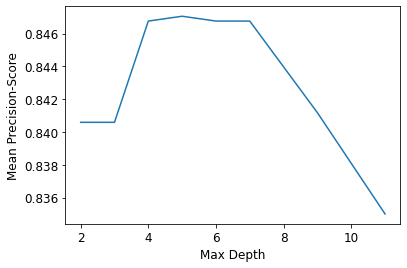

In [326]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error , f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV



# create an instance
dtc_political = DecisionTreeClassifier()

param_grid = {'max_depth':[2,3,4, 5,6, 7, 9, 11]}

grid = GridSearchCV(dtc_political,
                    param_grid, 
                    cv=5,
                    scoring='accuracy',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

# fit your model
#dtc_political.fit(X_train, y_train)
grid_search = grid.fit(X_train, y_train)
import matplotlib.pyplot as plt

plt.plot(param_grid['max_depth'],
         grid_search.cv_results_['mean_test_score'])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Mean Precision-Score', fontsize=12)

plt.show()

   

In [84]:
dtc_political = DecisionTreeClassifier(max_depth = 4)
dtc_political.fit(X_train, y_train)

# make predictions
preds = dtc_political.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)


MSE: 0.14470588235294118 
 Accuracy Score: 0.8552941176470589 
 Confusion Matrix: 
 [[288  48]
 [ 75 439]]


In [85]:
TestPrecision = precision_score(y_valid, preds)
TestAccuracy = accuracy_score(y_valid, preds)

print("Testing Accuracy Score = %.5f%%" % (TestAccuracy * 100))
print("Testing Precision Score = %.5f%%" % (TestPrecision * 100))

Testing Accuracy Score = 85.52941%
Testing Precision Score = 90.14374%


In [948]:
max(grid_search.cv_results_['mean_test_score'])

0.8452941176470589

In [50]:


predictions = grid_search.predict(X_valid)



# Report your accuracy
from sklearn.metrics import precision_score, accuracy_score # you can find your scoring metric in this library

TestPrecision = precision_score(y_valid, predictions)
TestAccuracy = accuracy_score(y_valid, predictions)

print("Testing Accuracy Score = %.5f%%" % (TestAccuracy * 100))
print("Testing Precision Score = %.5f%%" % (TestPrecision * 100))

Testing Accuracy Score = 85.52941%
Testing Precision Score = 91.50743%


In [51]:
def report(y_true_test, y_train_test, y_test_pred, y_train_pred):
    train_acc = metrics.accuracy_score(y_train_test, y_train_pred)
    test_acc = metrics.accuracy_score(y_true_test, y_test_pred)
    precision_score = metrics.precision_score(y_true_test, y_test_pred)
    recall_score = metrics.recall_score(y_true_test, y_test_pred)
    f1_score = metrics.f1_score(y_true_test, y_test_pred)
    print("Train set Accuracy: ", train_acc)
    print("Test set Accuracy: ", test_acc)
    print("precision_score: ", precision_score)
    print("recall_score: ", recall_score)
    print("f1_score: ", f1_score)

def scorelist(y_true_test, y_train_test, y_test_pred, y_train_pred):
    train_acc = metrics.accuracy_score(y_train_test, y_train_pred)
    test_acc = metrics.accuracy_score(y_true_test, y_test_pred)
    precision_score = metrics.precision_score(y_true_test, y_test_pred)
    recall_score = metrics.recall_score(y_true_test, y_test_pred)
    f1_score = metrics.f1_score(y_true_test, y_test_pred)
    return [train_acc,test_acc,precision_score,recall_score,f1_score]

In [459]:

randomf_politic = RandomForestClassifier()
randomf_politic.fit(X_train, y_train)
randomf_politic_test_pred = randomf_politic.predict(X_valid)
randomf_politic_train_pred = randomf_politic.predict(X_train)
report(y_valid, y_train, randomf_politic_test_pred, randomf_politic_train_pred)

Train set Accuracy:  0.9064705882352941
Test set Accuracy:  0.8741176470588236
precision_score:  0.9266247379454927
recall_score:  0.8599221789883269
f1_score:  0.8920282542885974


In [460]:
param_grid = {"max_features" : ['auto', 'sqrt'],
              "max_depth" : sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 10),
              "min_samples_leaf": sp_randint(1, 5),
              "bootstrap" : [True, False],
              "n_estimators" : [int(x) for x in np.linspace(start = 10, stop = 310, num = 10)]}

RF = RandomForestClassifier(random_state=100)
randomf_politic_hyper = RandomizedSearchCV(estimator=RF, param_distributions = param_grid, cv=10, n_iter= 10, random_state=100)
randomf_politic_hyper.fit(X_train, y_train)
print(randomf_politic_hyper.best_params_)

C:\Users\Msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Random

{'bootstrap': True, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 43}


In [461]:
randomf_politic_hyper_test_pred = randomf_politic_hyper.predict(X_valid)
randomf_politic_hyper_train_pred = randomf_politic_hyper.predict(X_train)
report(y_valid, y_train, randomf_politic_hyper_test_pred, randomf_politic_hyper_train_pred)
randomforestscores = scorelist(y_valid, y_train, randomf_politic_hyper_test_pred, randomf_politic_hyper_train_pred)

Train set Accuracy:  0.8623529411764705
Test set Accuracy:  0.8717647058823529
precision_score:  0.9124236252545825
recall_score:  0.8715953307392996
f1_score:  0.891542288557214


In [274]:
model_list = [('Random Forest', randomforestscores[0],randomforestscores[1],randomforestscores[2],randomforestscores[3],randomforestscores[4] )]  

In [275]:
model_stats = pd.DataFrame(data = model_list, columns=["Model",'Train Set Accuracy', 'Test Set Accuracy','Precision Score', 'Recall Score', 'F1 Score']).sort_values("Test Set Accuracy", ascending=False, ignore_index=True)
model_stats.index += 1
model_stats.style.background_gradient(cmap='Blues')

,Model,Train Set Accuracy,Test Set Accuracy,Precision Score,Recall Score,F1 Score
1,Random Forest,0.862353,0.871765,0.912424,0.871595,0.891542


In [462]:

# make predictions
preds = randomf_politic_hyper.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.12823529411764706 
 Accuracy Score: 0.8717647058823529 
 Confusion Matrix: 
 [[293  43]
 [ 66 448]]


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [331]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [332]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,num_political_names,num_username_numbers,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all,screen_name,isBot
0,1301168604667355142,Doğabilim,dogabilimorg,,Gerçek Bilginin Işığında!\nYayınlarımıza ulaşm...,803,93,109,0.896205,0,0,0.03,1.0,194,6,200,148,1,0.74,dogabilimorg,No
1,628886610,Esra Nur ÖZDEN,esranurmuratozd,Turkey,📍Güzeller güzeli 4 melek annesi\n📍Ak Parti Ank...,1962,1650,134,0.543189,1,0,0.985,0.0,3,197,200,181,1,0.905,esranurmuratozd,No
2,547532939,Kübra Şakır,kubussskr,iskenderun,'Allah'tan başka uğruna koştuğun hiçbir şey dü...,531,137,86,0.794910,0,0,0.52356,0.0,91,100,191,164,0,0.858639,kubussskr,No
3,946826934,Gökhan İZGİ 🇹🇷🇦🇿,gokhanizgi34,"İstanbul, Türkiye",📰 Gazeteci - Yazar | 📘 S.O.S.YAL MEDYA kitabı...,42188,33979,146,0.553888,0,0,0.32,1.0,136,64,200,74,0,0.37,gokhanizgi34,No
4,802201284833067009,Oral Orhon,orhonoral1975,"İstanbul, Türkiye","Holigan değil, sağlıklı ve Atatürkçü bir BEŞİK...",3988,4995,78,0.443950,0,0,0.393939,0.0,120,78,198,193,0,0.974747,orhonoral1975,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,1338444706204835840,laito proof,vtaeskit,eu ar55 childe main,namjoon yalvaririm telefonlarimi ac,270,673,35,0.286320,0,0,0.05,1.0,190,10,200,175,0,0.875,vtaeskit,No
2995,323513738,Ezgobar,shaammone,İzmir,humanoid 🏉 🏳️‍🌈,521,330,15,0.612221,0,0,0.025,1.0,195,5,200,95,0,0.475,shaammone,No
2996,1451270540669378572,Havva Sert,havvasert19,,,155,199,0,0.437853,0,0,0.835052,0.0,32,162,194,143,0,0.737113,havvasert19,No
2997,1354034188815654912,airi,airilynx,♡🧷she/her 18,#mitski ; i start the day high and it ends so ...,712,585,82,0.548959,0,0,0.12,1.0,176,24,200,143,1,0.715,airilynx,No


In [333]:

dfBotAll_train = pd.concat([all_annotation_user, dfBotAll_train], ignore_index=True)
dfBotAll_train = dfBotAll_train.fillna(0)

dfBotAll_train


,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,num_political_names,num_username_numbers,retweet_total_ratio,num_median_favorites,num_of_tweets,num_of_retweets,num_of_alltweets,same_day_tweets_total,same_tweet,same_day_to_all,isBot,screen_name
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0,0.060000,1.0,188,12,200,124,0,0.620000,No,0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0,0.200000,107.0,160,40,200,48,0,0.240000,No,0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,1,0,0.230000,1.0,154,46,200,132,0,0.660000,No,0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0,0.000000,0.0,0,0,0,0,0,0.000000,Not sure,0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,2,1.000000,0.0,0,200,200,198,1,0.990000,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4244,1338444706204835840,laito proof,vtaeskit,eu ar55 childe main,namjoon yalvaririm telefonlarimi ac,270,673,35,0.286320,0,0,0.050000,1.0,190,10,200,175,0,0.875000,No,vtaeskit
4245,323513738,Ezgobar,shaammone,İzmir,humanoid 🏉 🏳️‍🌈,521,330,15,0.612221,0,0,0.025000,1.0,195,5,200,95,0,0.475000,No,shaammone
4246,1451270540669378572,Havva Sert,havvasert19,,,155,199,0,0.437853,0,0,0.835052,0.0,32,162,194,143,0,0.737113,No,havvasert19
4247,1354034188815654912,airi,airilynx,♡🧷she/her 18,#mitski ; i start the day high and it ends so ...,712,585,82,0.548959,0,0,0.120000,1.0,176,24,200,143,1,0.715000,No,airilynx


In [67]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

In [334]:
dfBotAll_train[['retweet_total_ratio', 'num_median_favorites', 'num_of_alltweets', 'num_of_retweets', 'num_of_tweets', 'same_tweet','same_day_to_all', 'same_day_tweets_total' ]] = dfBotAll_train[['retweet_total_ratio', 'num_median_favorites',  'num_of_alltweets', 'num_of_retweets', 'num_of_tweets', 'same_tweet','same_day_to_all', 'same_day_tweets_total'  ]]


### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [464]:
X = dfBotAll_train[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites', 'num_username_numbers', 'num_political_names', 'num_of_retweets', 'num_of_tweets','same_tweet','same_day_to_all', 'same_day_tweets_total']]
y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

### 2.2.3. Train-test split

In [465]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. Train the model

In [413]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, f1_score, precision_score, recall_score

# create an instance
dtc_bot = DecisionTreeClassifier(max_depth = 15)

# fit your model
dtc_bot.fit(X_train, y_train)

# make predictions
preds = dtc_bot.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
f1_score = f1_score(y_valid, preds)


print(
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Accuracy Score: 0.8270588235294117 
 Confusion Matrix: 
 [[674  64]
 [ 83  29]]


In [72]:
X_valid.count()

description_len           850
followers_to_all_ratio    850
retweet_total_ratio       850
num_median_favorites      850
num_username_numbers      850
num_political_names       850
num_of_retweets           850
num_of_tweets             850
same_tweet                850
same_day_to_all           850
same_day_tweets_total     850
dtype: int64

Fitting 5 folds for each of 7 candidates, totalling 35 fits


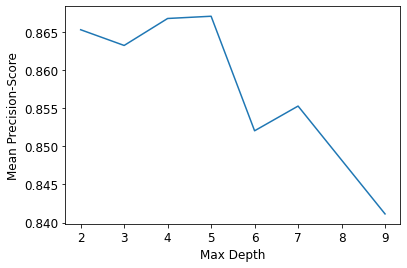

In [308]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV



# create an instance
dtc_political = DecisionTreeClassifier()

param_grid = {'max_depth':[2,3,4, 5,6, 7, 9]}

grid = GridSearchCV(dtc_political,
                    param_grid, 
                    cv=5,
                    scoring='accuracy',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

# fit your model
#dtc_political.fit(X_train, y_train)
grid_search = grid.fit(X_train, y_train)
import matplotlib.pyplot as plt

plt.plot(param_grid['max_depth'],
         grid_search.cv_results_['mean_test_score'])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Mean Precision-Score', fontsize=12)

plt.show()

In [316]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, f1_score, precision_score, recall_score

# create an instance
dtc_bot = KNeighborsClassifier(n_neighbors=3)

# fit your model
dtc_bot.fit(X_train, y_train)

# make predictions
preds = dtc_bot.predict(X_valid)

# evaluate on validation set
mse = mean_squared_error(y_valid, preds)
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
precision = precision_score(y_valid, preds)
recall = recall_score(y_valid, preds)
f1_score = f1_score(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "F1 score:", f1_score, "\n",
      "Precision:", precision, "\n",
      "Recall:", recall, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.16470588235294117 
 Accuracy Score: 0.8352941176470589 
 F1 score: 0.20454545454545459 
 Precision: 0.28125 
 Recall: 0.16071428571428573 
 Confusion Matrix: 
 [[692  46]
 [ 94  18]]


In [287]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

# initialize the values of k:
param_grid = {'n_neighbors':[1,3,5,7,9,11,13,15]}

# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    scoring='accuracy',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

grid_search = grid.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


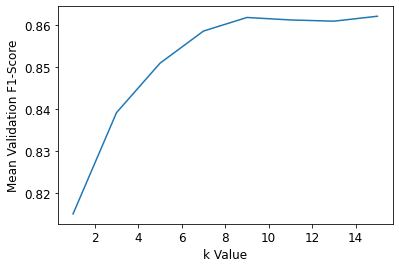

In [288]:
import matplotlib.pyplot as plt

plt.plot(param_grid['n_neighbors'],
         grid_search.cv_results_['mean_test_score'])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel('k Value', fontsize=12)
plt.ylabel('Mean Validation F1-Score', fontsize=12)

plt.show()

In [489]:
randomf_bot = RandomForestClassifier()
randomf_bot.fit(X_train, y_train)
randomf_bot_test_pred = randomf_bot.predict(X_valid)
randomf_bot_train_pred = randomf_bot.predict(X_train)
report(y_valid, y_train, randomf_bot_test_pred, randomf_bot_train_pred)

Train set Accuracy:  0.9920564872021183
Test set Accuracy:  0.8764705882352941
precision_score:  0.574468085106383
recall_score:  0.24107142857142858
f1_score:  0.33962264150943394


In [490]:

# make predictions
preds = randomf_bot.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.12352941176470589 
 Accuracy Score: 0.8764705882352941 
 Confusion Matrix: 
 [[718  20]
 [ 85  27]]


In [491]:
param_grid = {"max_features" : ['auto', 'sqrt'],
              "max_depth" : sp_randint(1, 10),
              "min_samples_split": sp_randint(2, 10),
              "min_samples_leaf": sp_randint(1, 5),
              "bootstrap" : [True, False],
              "n_estimators" : [int(x) for x in np.linspace(start = 10, stop = 310, num = 10)]}

RF = RandomForestClassifier(random_state=100)
randomf_bot_hyper = RandomizedSearchCV(estimator=RF, param_distributions = param_grid, cv=10, n_iter= 10, random_state=100)
randomf_bot_hyper.fit(X_train, y_train)
print(randomf_bot_hyper.best_params_)

C:\Users\Msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\Msi\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for Random

{'bootstrap': True, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 43}


In [492]:
model_list = [('Random Forest', randomforestscores[0],randomforestscores[1],randomforestscores[2],randomforestscores[3],randomforestscores[4] )]  

In [493]:
model_stats = pd.DataFrame(data = model_list, columns=["Model",'Train Set Accuracy', 'Test Set Accuracy','Precision Score', 'Recall Score', 'F1 Score']).sort_values("Test Set Accuracy", ascending=False, ignore_index=True)
model_stats.index += 1
model_stats.style.background_gradient(cmap='Blues')

,Model,Train Set Accuracy,Test Set Accuracy,Precision Score,Recall Score,F1 Score
1,Random Forest,0.862353,0.871765,0.912424,0.871595,0.891542


In [494]:

# make predictions
preds = randomf_bot.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.12352941176470589 
 Accuracy Score: 0.8764705882352941 
 Confusion Matrix: 
 [[718  20]
 [ 85  27]]


In [358]:
preds = randomf_bot_hyper.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)
mse = mean_squared_error(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.1388235294117647 
 Accuracy Score: 0.8611764705882353 
 Confusion Matrix: 
 [[727  11]
 [107   5]]


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [503]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('evaluation-round3-tweet.csv', dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfPolitical_test[['num_political_entities','total_interactions','is_retweet_politic','num_hashtags', 'num_retweets', 'num_non_political_entities', 'description_political', 'sport_ent', 'religion_ent', 'has_link']]
# make predictions based on these variables
predictions_political = randomf_politic_hyper.predict(X)

### This part is important! We expect you to return your predictions in the following format:

## 3.2. Predictions for Users (Bot or Not)

In [505]:
evaluationUserDf = pd.read_csv('evaluation-round3-user.csv', dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
dfBot_test = dfBot_test.fillna(0)
X = dfBot_test[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites', 'num_username_numbers', 'num_political_names', 'num_of_retweets', 'num_of_tweets','same_tweet','same_day_to_all', 'same_day_tweets_total']]

# make predictions based on these variables
predictions_bot = randomf_bot.predict(X)

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

You can check whether you can read your predictions correctly or not: